This notebook contains 4 models using a TFIDF Feature Vectoriser 
1. MLP 
2. LSTM 
3. BILSTM 
4. BILSTM WITH MAX POOLING

# Initialization

In [13]:
# Standard library imports
import os
import random
from csv import DictReader, DictWriter

# Third-party imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

# Machine learning and model building
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# TensorFlow and Keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Concatenate, Bidirectional, LSTM, Dropout, Dense, BatchNormalization, LayerNormalization
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint


In [14]:
# Initialise global variables
base_kaggle_input_path = "/kaggle/input"
base_kaggle_path = "/kaggle"
base_kaggle_working_path = "/kaggle/working"

label_ref = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}
label_ref_rev = {0: 'agree', 1: 'disagree', 2: 'discuss', 3: 'unrelated'}
stop_words = [
        "a", "about", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along",
        "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
        "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as", "at", "back", "be",
        "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
        "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom", "but", "by", "call", "can", "co",
        "con", "could", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight",
        "either", "eleven", "else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
        "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill", "find", "fire", "first", "five", "for",
        "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had",
        "has", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself",
        "him", "himself", "his", "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed", "interest",
        "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made",
        "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much",
        "must", "my", "myself", "name", "namely", "neither", "nevertheless", "next", "nine", "nobody", "now", "nowhere",
        "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours",
        "ourselves", "out", "over", "own", "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see",
        "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some",
        "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take",
        "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby",
        "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though",
        "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve",
        "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what",
        "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon",
        "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will",
        "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"
        ]

# Set file names
file_train_instances = base_kaggle_working_path +"/train_instances.csv"
file_train_bodies = base_kaggle_working_path +"/train_bodies.csv"
file_test_instances = base_kaggle_working_path +"/test_instances.csv"
file_test_bodies = base_kaggle_working_path +"/test_bodies.csv"
file_predictions = "predictions_test.csv"
file_valid_instances = base_kaggle_working_path +"/valid_instances.csv"
file_valid_bodies = base_kaggle_working_path +"/valid_bodies.csv"

# Initialise hyperparameters
r = random.Random()
lim_unigram = 5000
target_size = 4
hidden_size = 100
train_keep_prob = 0.6
l2_alpha = 0.00001
learn_rate = 0.01
clip_ratio = 5
batch_size_train = 500
epochs = 90

In [15]:
#Data Loading
for dirname, _, filenames in os.walk(base_kaggle_input_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

def load_data(base_path):
    """ Load datasets and return them as Pandas DataFrames. """
    train_df = pd.read_csv(os.path.join(base_path, "lemma-balanced/lemmatized_dataset_final_balanced_train.csv"))
    test_df = pd.read_csv(os.path.join(base_path, "lemma-balanced/lemmatized_dataset_final_balanced_test.csv"))
    valid_df = pd.read_csv(os.path.join(base_path, "lemma-balanced/lemmatized_dataset_final_balanced_validation.csv"))
    return train_df, test_df, valid_df

def extract_data(df, data_type):
    if data_type == 'instances':
        return df[["Headline", "Body ID", "Stance"]]
    elif data_type == 'bodies':
        return df[["Body ID", "articleBody"]]
    elif data_type == 'labels':
        return df["Stance"]
    else:
        raise ValueError("Invalid data type specified. Choose 'instances', 'bodies', or 'labels'.")

def split_instances_bodies_labels_and_export_csv(train_df, test_df, valid_df):
    
    train_instances = extract_data(train_df, 'instances')
    train_instances.to_csv("train_instances.csv", index=False)
    
    train_bodies = extract_data(train_df, 'bodies')
    train_bodies.to_csv("train_bodies.csv", index=False)
    
    test_instances = extract_data(test_df, 'instances')
    test_instances.to_csv("test_instances.csv", index=False)
    
    test_bodies = extract_data(test_df, 'bodies')
    test_bodies.to_csv("test_bodies.csv", index=False)
    
    test_labels = extract_data(test_df, 'labels')
    test_labels.to_csv("test_labels.csv", index=False)
        
    valid_instances = extract_data(valid_df, 'instances')
    valid_instances.to_csv("valid_instances.csv", index=False)
    
    valid_bodies = extract_data(valid_df, 'bodies')
    valid_bodies.to_csv("valid_bodies.csv", index=False)

    valid_labels = extract_data(valid_df, 'labels')
    valid_labels.to_csv("valid_labels.csv", index=False)
    
    return train_instances, train_bodies, test_instances, test_bodies, test_labels, valid_instances, valid_bodies, valid_labels
    


/kaggle/input/fake-news-challenge/train_stances.csv
/kaggle/input/fake-news-challenge/test_stances_unlabeled.csv
/kaggle/input/fake-news-challenge/train_bodies.csv
/kaggle/input/fake-news-challenge/competition_test_bodies.csv
/kaggle/input/fake-news-challenge/competition_test_stances_unlabeled.csv
/kaggle/input/fake-news-challenge/test_bodies.csv
/kaggle/input/lemma-balanced/lemmatized_dataset_final_balanced_train.csv
/kaggle/input/lemma-balanced/lemmatized_dataset_final_balanced_validation.csv
/kaggle/input/lemma-balanced/lemmatized_dataset_final_balanced_test.csv


In [16]:
# FNC Data Class
class FNCData:
    """
    Define class for Fake News Challenge data
    """
    def __init__(self, file_instances, file_bodies):
        # Load data
        self.instances = self.read(file_instances)
        bodies = self.read(file_bodies)
        self.heads = {}
        self.bodies = {}

        # Process instances
        for instance in self.instances:
            if instance['Headline'] not in self.heads:
                head_id = len(self.heads)
                self.heads[instance['Headline']] = head_id
            instance['Body ID'] = int(instance['Body ID'])

        # Process bodies
        for body in bodies:
            self.bodies[int(body['Body ID'])] = body['articleBody']

    def read(self, filename):
        """
        Read Fake News Challenge data from CSV file

        Args:
            filename: str, filename + extension

        Returns:
            rows: list, of dict per instance
        """
        # Initialise
        rows = []

        # Process file
        with open(filename, "r", encoding='utf-8') as table:
            r = DictReader(table)
            for line in r:
                rows.append(line)

        return rows

# Define relevant functions
def pipeline_train(train, test, lim_unigram):
    """
    Process train set, create relevant vectorizers

    Args:
        train: FNCData object, train set
        test: FNCData object, test set
        lim_unigram: int, number of most frequent words to consider

    Returns:
        train_set: list, of numpy arrays
        train_stances: list, of ints
        bow_vectorizer: sklearn CountVectorizer
        tfreq_vectorizer: sklearn TfidfTransformer(use_idf=False)
        tfidf_vectorizer: sklearn TfidfVectorizer()
    """
    # Initialise
    heads = []
    heads_track = {}
    bodies = []
    bodies_track = {}
    body_ids = []
    id_ref = {}
    train_set = []
    train_stances = []
    cos_track = {}
    test_heads = []
    test_heads_track = {}
    test_bodies = []
    test_bodies_track = {}
    test_body_ids = []
    head_tfidf_track = {}
    body_tfidf_track = {}

    # Identify unique heads and bodies
    for instance in train.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in heads_track:
            heads.append(head)
            heads_track[head] = 1
        if body_id not in bodies_track:
            bodies.append(train.bodies[body_id])
            bodies_track[body_id] = 1
            body_ids.append(body_id)

    # Create reference dictionary
    for i, elem in enumerate(heads + body_ids):
        id_ref[elem] = i

    # Create vectorizers and BOW and TF arrays for train set
    bow_vectorizer = CountVectorizer(max_features=lim_unigram, stop_words=stop_words)
    bow = bow_vectorizer.fit_transform(heads + bodies)  # Train set only

    tfreq_vectorizer = TfidfTransformer(use_idf=False).fit(bow)
    tfreq = tfreq_vectorizer.transform(bow).toarray()  # Train set only

    tfidf_vectorizer = TfidfVectorizer(max_features=lim_unigram, stop_words=stop_words).fit(heads + bodies)  # Train and test sets

    # Process train set
    for instance in train.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        head_tf = tfreq[id_ref[head]].reshape(1, -1)
        body_tf = tfreq[id_ref[body_id]].reshape(1, -1)
        if head not in head_tfidf_track:
            head_tfidf = tfidf_vectorizer.transform([head]).toarray()
            head_tfidf_track[head] = head_tfidf
        else:
            head_tfidf = head_tfidf_track[head]
        if body_id not in body_tfidf_track:
            body_tfidf = tfidf_vectorizer.transform([train.bodies[body_id]]).toarray()
            body_tfidf_track[body_id] = body_tfidf
        else:
            body_tfidf = body_tfidf_track[body_id]
        if (head, body_id) not in cos_track:
            tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
            cos_track[(head, body_id)] = tfidf_cos
#           cos_track[(helemmatized_dataset_final_balanced_trainad, body_id)] = tfidf_cos
        else:
            tfidf_cos = cos_track[(head, body_id)]
        feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
        train_set.append(feat_vec)
        train_stances.append(label_ref[instance['Stance']])

    return train_set, train_stances, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer

def pipeline_test(test, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer):
    """
    Process test set

    Args:
        test: FNCData object, test set
        bow_vectorizer: sklearn CountVectorizer
        tfreq_vectorizer: sklearn TfidfTransformer(use_idf=False)
        tfidf_vectorizer: sklearn TfidfVectorizer()

    Returns:
        test_set: list, of numpy arrays
    """
    # Initialise
    test_set = []
    heads_track = {}
    bodies_track = {}
    cos_track = {}

    # Process test set
    for instance in test.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in heads_track:
            head_bow = bow_vectorizer.transform([head]).toarray()
            head_tf = tfreq_vectorizer.transform(head_bow).toarray()[0].reshape(1, -1)
            head_tfidf = tfidf_vectorizer.transform([head]).toarray().reshape(1, -1)
            heads_track[head] = (head_tf, head_tfidf)
        else:
            head_tf = heads_track[head][0]
            head_tfidf = heads_track[head][1]
        if body_id not in bodies_track:
            body_bow = bow_vectorizer.transform([test.bodies[body_id]]).toarray()
            body_tf = tfreq_vectorizer.transform(body_bow).toarray()[0].reshape(1, -1)
            body_tfidf = tfidf_vectorizer.transform([test.bodies[body_id]]).toarray().reshape(1, -1)
            bodies_track[body_id] = (body_tf, body_tfidf)
        else:
            body_tf = bodies_track[body_id][0]
            body_tfidf = bodies_track[body_id][1]
        if (head, body_id) not in cos_track:
            tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
            cos_track[(head, body_id)] = tfidf_cos
        else:
            tfidf_cos = cos_track[(head, body_id)]
        feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
        test_set.append(feat_vec)

    return test_set

def load_model(sess):
    """
    Load TensorFlow model

    Args:
        sess: TensorFlow session
    """
    saver = tf.train.Saver()
    saver.restore(sess, './model/model.checkpoint')

def save_predictions(pred, file):
    """
    Save predictions to CSV file

    Args:
        pred: numpy array, of numeric predictions
        file: str, filename + extension
    """
    with open(file, 'w') as csvfile:
        fieldnames = ['Stance']
        writer = DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for instance in pred:
            writer.writerow({'Stance': label_ref_rev[instance]})

In [17]:
def remove_exact_rows(merged_df):
    # Check if all rows are exactly the same
    all_same = merged_df.duplicated(keep=False)
    
    # Filter out rows where all values match
    matched_instances =  merged_df[all_same]

    # Print the matched instances
    print("Cases where all rows are exactly the same:")
    print(matched_instances)
    
    return matched_instances

In [18]:
# Read input dataset CSV files
train_df, test_df, valid_df = load_data(base_kaggle_input_path)
train_instances, train_bodies, test_instances, test_bodies, test_labels, valid_instances, valid_bodies, valid_labels =  split_instances_bodies_labels_and_export_csv(train_df, test_df, valid_df)

# Merge train_df and test_df
merged_df = pd.merge(train_df, test_df, how="inner", suffixes=('_train', '_test'))
matched_instances = remove_exact_rows(merged_df)

# Load data sets
raw_train = FNCData(file_train_instances, file_train_bodies)
raw_test = FNCData(file_test_instances, file_test_bodies)
raw_valid= FNCData(file_valid_instances, file_valid_bodies)
n_train = len(raw_train.instances)

# Process data sets
train_set, train_stances, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer = \
    pipeline_train(raw_train, raw_test, lim_unigram=lim_unigram)
feature_size = len(train_set[0])
valid_set = pipeline_test(raw_valid, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer)
test_set = pipeline_test(raw_test, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer)

test_labels = pd.read_csv(base_kaggle_working_path + "/test_labels.csv")
test_labels['stance_cat'] = test_labels['Stance'].map(label_ref).astype(int)
stan = test_labels['stance_cat'].tolist()

valid_labels = pd.read_csv(base_kaggle_working_path + "/valid_labels.csv")
valid_labels['stance_cat'] = valid_labels['Stance'].map(label_ref).astype(int)
val_lab = valid_labels['stance_cat'].tolist()


Cases where all rows are exactly the same:
Empty DataFrame
Columns: [Headline, Body ID, Stance, articleBody, stance_cat]
Index: []


In [19]:
# Split data into train and validation sets
X_train, y_train = train_set, train_stances
X_val, y_val = valid_set, val_lab
X_val = np.stack(X_val, axis=0)

X_test, y_test = test_set, test_labels

# Ensure that y_val is also converted to a numpy array
y_val = np.array(y_val)
y_test = np.array(y_test)

# Concatenate or stack the arrays in train_set
X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)

# Ensure that train_stances is also converted to a numpy array
y_train = np.array(y_train)

# Define input shape
input_similarity = Input(shape=(feature_size,), name='input_similarity')

In [20]:
test_df.head()

,Headline,Body ID,Stance,articleBody,stance_cat
0,god is a woman priest who died for 48 minute c...,1227,disagree,a supposed catholic priest claim of seeing god...,1
1,update internet report of ebola outbreak in pu...,958,unrelated,an animal lover from norfolk splashed hundred ...,3
2,british hostage david haines beheaded by islam...,2034,unrelated,when a report went viral that nbc meteorologis...,3
3,video messaging service verifies timing of cnn...,1435,unrelated,apple may be planning to hold a special event ...,3
4,omar gonzalez white house fencejumper made it ...,917,unrelated,source detroit free press yesterday we reporte...,3


In [21]:
bodyId = test_df["Body ID"].tolist()
headline = test_df["Headline"].tolist()
articleBody = test_df["articleBody"].tolist()

# MLP

In [22]:
class MLPModel:
    def __init__(self):
        self.model_img_filename = "model_tf-idf_mlp.png"
        self.model_best_checkpoint_filename = "MLP_best_model.keras"
        self.model = None
        self.model_checkpoint = None
        self.initialize_model()
        self.history = None
        self.predicted_labels = None
        self.RELATED = [0, 1, 2]  # 'agree':0,'disagree':1,'discuss':2,'unrelated':3
        self.accuracy = None
        self.custom_score = None

    def initialize_model(self):
        # Define the model architecture
        dense1 = Dense(64, activation='relu')(input_similarity)
        drop = Dropout(0.25)(dense1)
        output = Dense(4, activation='softmax')(drop)
        
        # Create and compile model
        self.model = tf.keras.Model(inputs=input_similarity, outputs=output)
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Display summary
        self.summary()
        
        self.plot_model()

    def summary(self):
        if self.model:
            self.model.summary()
        else:
            print("Model is not initialized yet.")

    def plot_model(self):
        if self.model:
            plot_model(self.model, to_file=self.model_img_filename, show_shapes=True, show_layer_names=True)
            display(Image(filename=self.model_img_filename))
        else:
            print("Model is not initialized yet.")

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        if not self.model:
            print("Model is not initialized. Please initialize the model before training.")
            return
        
        # Callback to save the best model based on validation loss
        checkpoint = ModelCheckpoint(self.model_best_checkpoint_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        
        # Train the model
        self.history = self.model.fit(
            X_train, y_train, 
            validation_data=(X_val, y_val),
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[checkpoint]
        )
        return self.history
    
    def plot_training_history(self):
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
            
    def export_results_to_csv(self, y_test, predicted_classes, correct_predictions, bodyId, headline, articleBody):
        # Assuming y_test, predicted_classes, and correct_predictions are NumPy arrays or lists
        # Stack the arrays horizontally (i.e., column-wise)
        results_array = np.column_stack((bodyId, headline, articleBody, y_test, predicted_classes, correct_predictions))

        # Optionally convert array elements to string for CSV format and add header
        header = "bodyId, headline, articleBody, Ground Truth, Ground Truth Label, Predicted Label, Correctly Classified"
        fmt = '%s'  # Define string format for saving string data, or '%d', '%f' for integers, floats

        # Save to CSV file
        np.savetxt('MLP_best_model_predictions.csv', results_array, delimiter=',', header=header, comments='', fmt=fmt)
        print("Predictions and accuracy exported to MLP_best_model_predictions.csv.")

        
    def evaluate_model(self, use_checkpoint=False):
        if use_checkpoint:
            if self.model is None:
                print("Model architecture is not defined. Define the model architecture before loading weights.")
                return
            
            y_test_code = y_test[:, 1].astype(int)  # Convert to integers if not already
            
            # Load the best model from the checkpoint
            self.model.load_weights(self.model_best_checkpoint_filename)
            print("Loaded model from checkpoint.")

            # Evaluate the model on the test data
            loss, accuracy = self.model.evaluate(X_test, y_test_code)
            print('Test Loss:', loss)
            print('Test Accuracy:', accuracy)

            # Making predictions
            predictions = self.model.predict(X_test)
            predicted_classes = np.argmax(predictions, axis=1)

            # Check if predictions are correct
            correct_predictions = (predicted_classes == y_test_code).astype(int)  # 1 for correct, 0 for incorrect
            
            self.export_results_to_csv(y_test, predicted_classes, correct_predictions, bodyId, headline, articleBody)


    def plot_confusion_matrix(self):
        predictions = self.model.predict(np.stack(test_set))
        self.predicted_labels = np.argmax(predictions, axis=1)
        conf_matrix = confusion_matrix(np.array(stan), self.predicted_labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['agree', 'disagree', 'discuss', 'unrelated'], yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
        
    def calculate_metrics(self, y_test):
        predictions = self.model.predict(np.stack(X_test))
        self.predicted_labels = np.argmax(predictions, axis=1)
        self.accuracy = accuracy_score(y_test, self.predicted_labels)
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, self.predicted_labels, average='weighted')
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1_score)
        return accuracy, precision, recall, f1_score
    
    # Define your custom score function
    def score_submission(self, gold_labels, test_labels):
        score = 0.0

        for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
            g_stance, t_stance = g, t
            if g_stance == t_stance:
                score += 0.25
                if g_stance != 'unrelated':
                    score += 0.50
            if g_stance in self.RELATED and t_stance in self.RELATED:
                score += 0.25

        return score

    def report_score(self, actual,predicted):
        score = self.score_submission(actual,predicted)
        best_score = self.score_submission(actual,actual)

        print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
        return score*100/best_score
    
    def custom_scoring(self):
        
        self.accuracy = accuracy_score(stan, self.predicted_labels)
        
        # Calculate precision, recall, F1-score using scikit-learn
        precision, recall, f1_score, _ = precision_recall_fscore_support(stan, self.predicted_labels, average='weighted')
        
        self.custom_score = self.score_submission(stan, self.predicted_labels)
        report_sc = self.report_score(stan, self.predicted_labels)

        # Print all the metrics
        # print("Accuracy:", accuracy)
        # print("Precision:", precision)
        # print("Recall:", recall)
        # print("F1 Score:", f1_score)
        return self.custom_score
    
    def accuracy_metrics(self):
        # Calculate precision, recall, F1-score for each class using scikit-learn
        precision, recall, f1_score, _ = precision_recall_fscore_support(stan, self.predicted_labels, average=None)

        # Print class-wise F1 scores
        for i in range(len(precision)):
            print(f"Class {i} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1_score[i]}")

        # Print all the metrics
        print("Accuracy:", self.accuracy)
        print("Macro Precision:", precision.mean())
        print("Macro Recall:", recall.mean())
        print("Macro F1 Score:", f1_score.mean())
        print("Custom Score:", self.custom_score)
        
    # def model_predict(self, use_checkpoint=False, inputHeader, inputBody):
    #     if use_checkpoint:
    #         if self.model is None:
    #             print("Model architecture is not defined. Define the model architecture before loading weights.")
    #             return
            
    #         # Load the best model from the checkpoint
    #         self.model.load_weights(self.model_best_checkpoint_filename)
    #         print("Loaded model from checkpoint.")
            
    #         inputHeader = str(inputHeader)
    #         inputBody = str(inputBody)
    #         self.model.predict(inputHeader, inpu)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_similarity (InputLayer)   │ (None, 10001)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,388 (2.44 MB)

 Trainable params: 640,388 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

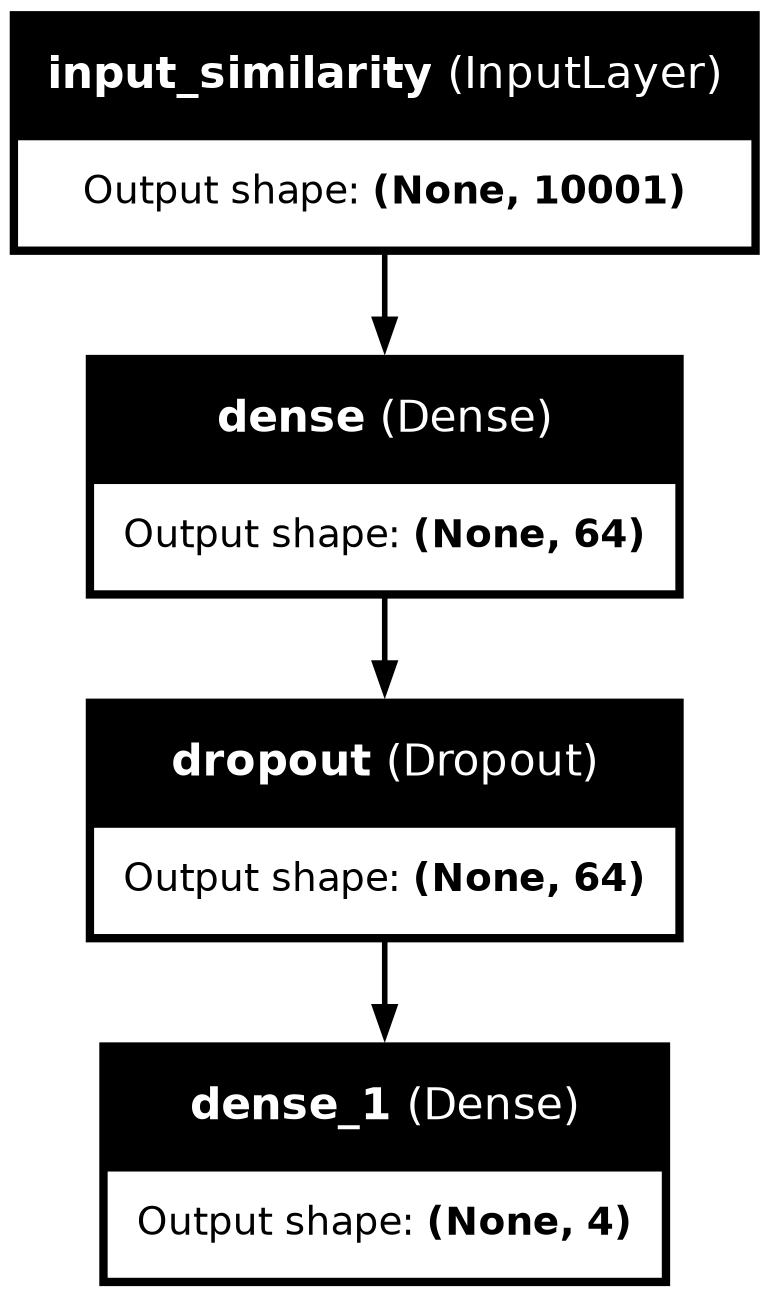

In [23]:
myMLPModel = MLPModel()

In [24]:
myMLPModel.train(X_train, y_train, X_val, y_val, epochs, batch_size_train)

Epoch 1/90
17/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4577 - loss: 1.3204

I0000 00:00:1713235103.927182      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713235103.943424      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5029 - loss: 1.2339

W0000 00:00:1713235106.103767      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713235106.884952      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.94295, saving model to MLP_best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5039 - loss: 1.2313 - val_accuracy: 0.6329 - val_loss: 0.9430
Epoch 2/90
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6352 - loss: 0.9077
Epoch 2: val_loss improved from 0.94295 to 0.77938, saving model to MLP_best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6378 - loss: 0.9032 - val_accuracy: 0.7115 - val_loss: 0.7794
Epoch 3/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7306 - loss: 0.7412
Epoch 3: val_loss improved from 0.77938 to 0.65321, saving model to MLP_best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7310 - loss: 0.7405 - val_accuracy: 0.7837 - val_loss: 0.6532
Epoch 4/90
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8008 - loss: 0.6139
Epoch 4: val_loss improved from 0.65321 to 0.54735, saving model to MLP_best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - ac

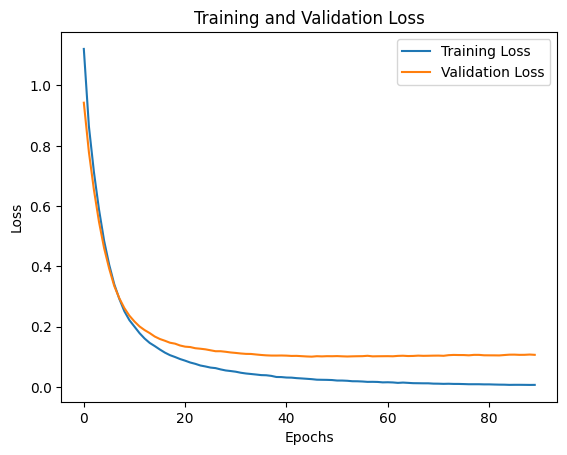

In [25]:
myMLPModel.plot_training_history()

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


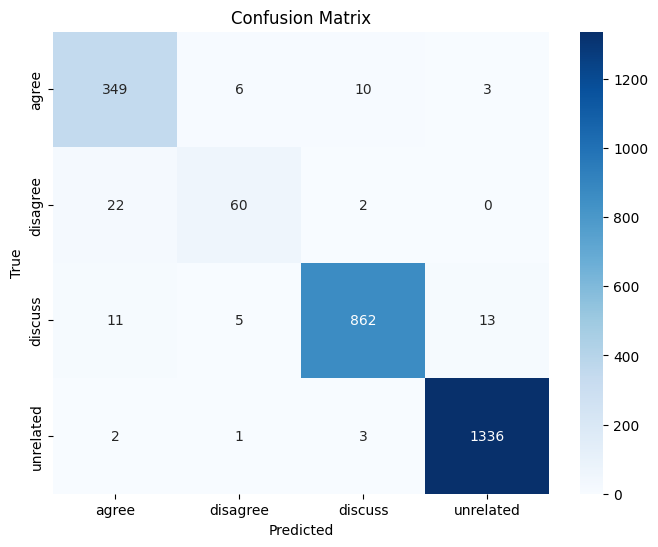

In [26]:
myMLPModel.plot_confusion_matrix()

In [27]:
myMLPModel.custom_scoring()

Score: 2287.0 out of 2349.5	(97.33985954458396%)


2287.0

In [28]:
myMLPModel.accuracy_metrics()

Class 0 - Precision: 0.9088541666666666, Recall: 0.9483695652173914, F1-score: 0.928191489361702
Class 1 - Precision: 0.8333333333333334, Recall: 0.7142857142857143, F1-score: 0.7692307692307692
Class 2 - Precision: 0.9828962371721779, Recall: 0.9674523007856342, F1-score: 0.9751131221719458
Class 3 - Precision: 0.9881656804733728, Recall: 0.9955290611028316, F1-score: 0.9918337045285821
Accuracy: 0.9709497206703911
Macro Precision: 0.9283123544113877
Macro Recall: 0.9064091603478928
Macro F1 Score: 0.9160922713232498
Custom Score: 2287.0


In [29]:
print(X_test[:10])

[[0.         0.         0.         ... 0.         0.         0.48483928]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.3069834 ]]


In [30]:
print(y_test[:10])

[['disagree' 1]
 ['unrelated' 3]
 ['unrelated' 3]
 ['unrelated' 3]
 ['unrelated' 3]
 ['unrelated' 3]
 ['discuss' 2]
 ['unrelated' 3]
 ['unrelated' 3]
 ['discuss' 2]]


In [31]:
myMLPModel.evaluate_model(True)

Loaded model from checkpoint.
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9691 - loss: 0.1050
Test Loss: 0.11132107675075531
Test Accuracy: 0.9668529033660889
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predictions and accuracy exported to MLP_best_model_predictions.csv.
